# Problem 1
- This notebook analyzes longitudinal Electronic Health Records (EHR) data from the Synthea SyntheticMass dataset to study the progression of Chronic Kidney Disease (CKD) across synthetic patients.

- I have the ICD-10 codes for Chronic Kindney Disease at various stages. But the codes that we have in the csvs are SNOMED CT diagnosis codes, so I found out mapping between ICD-10 and SNOMED CT online. Which I will use to identify the patients to track them

### Tasks
- Filter and label patient diagnoses using CKD-specific SNOMED codes (Stage 1 to ESRD).

- Trace each patient’s transition through CKD stages chronologically.

- Calculate the number of days between successive CKD stages for each patient.

- Report the mean and median durations for each stage-to-stage transition across the patient cohort.

### CSV's used
- The Synthea dataset provides a comprehensive, synthetic electronic health record system, with multiple CSVs covering various aspects of patient care—conditions, encounters, patients, procedures, medications, allergies, immunizations, and more.

- However, for this specific problem focused on Chronic Kidney Disease (CKD) progression, only a subset of files was essential and directly relevant to the core objectives.

   `conditions.csv` - Primary source for CKD diagnosis codes and staging information.

   `observations.csv`- Used to extract laboratory results, specifically eGFR values, which enable objective and guideline-based CKD staging and progression tracking.


- Rest csvs were not used to avoid scope creep to stay aligned with the assignment’s goal: understanding disease stage transitions over time.

- As we are dealing with highly relational data. I am starting by visualizing how the fields are connected across csv's

In [1]:
!pip install semantic-link

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.0/611.0 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.5/297.5 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.7.1
    Uninstalling traitlets-5.7.1:
      Successfully uninstalled traitlets-5.7.1
  Attempting uninstall: IPython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfu

In [2]:
import pandas as pd
from sempy.relationships import (
    find_relationships,
    plot_relationship_metadata
)

In [4]:
all_tables = {
    "allergies": pd.read_csv('allergies.csv'),
    "careplans": pd.read_csv('careplans.csv'),
    "claims": pd.read_csv('claims.csv'),
    "claims_transactions": pd.read_csv('claims_transactions.csv'),
    "conditions": pd.read_csv('conditions.csv'),
    "devices": pd.read_csv('devices.csv'),
    "encounters": pd.read_csv('encounters.csv'),
    "imaging_studies": pd.read_csv('imaging_studies.csv'),
    "immunizations": pd.read_csv('immunizations.csv'),
    "medications": pd.read_csv('medications.csv'),
    "observations": pd.read_csv('observations.csv'),
    "organizations": pd.read_csv('organizations.csv'),
    "patients": pd.read_csv('patients.csv'),
    "payer_transitions": pd.read_csv('payer_transitions.csv'),
    "payers": pd.read_csv('payers.csv'),
    "procedures": pd.read_csv('procedures.csv'),
    "providers": pd.read_csv('providers.csv'),
    "supplies": pd.read_csv('supplies.csv'),
}

INFO:SemPy:{'func': 'sempy.relationships._find.find_relationships', 'result.shape': (35, 13), 'tables': Counter({'pandas.core.frame.DataFrame': 18}), 'total_seconds': 1.58}
INFO:SemPy:{'func': 'sempy.relationships._plot.plot_relationship_metadata', 'metadata_df.type': 'pandas.core.frame.DataFrame', 'metadata_df.shape': (35, 13), 'tables': Counter({'i': 2, 'n': 2, 'e': 2, 'b': 1, 'u': 1, 'l': 1, 't': 1, 's': 1, '.': 1, 'N': 1, 'o': 1, 'T': 1, 'y': 1, 'p': 1}), 'total_seconds': 0.00904}


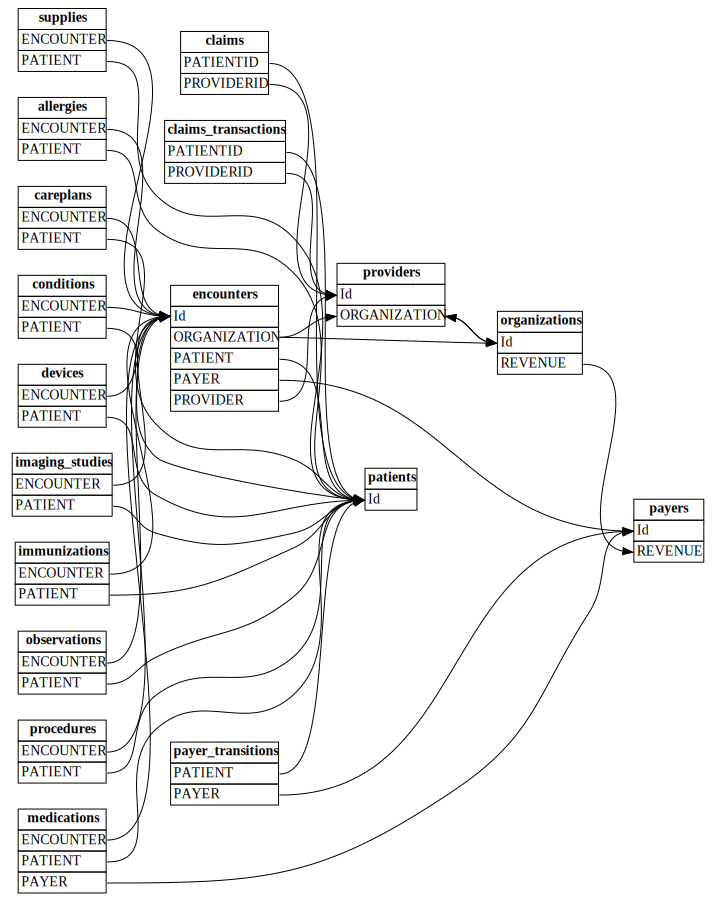

In [5]:
suggested_relationships = find_relationships(all_tables)
plot_relationship_metadata(suggested_relationships)

- The main data we need to solve lies in observations.csv and conditions.csv

In [3]:
conditions = pd.read_csv("conditions.csv")
conditions

,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION
0,2015-02-19,2017-03-02,74fb7318-9e69-35ea-266c-3bee58c2d31a,9a290e20-8f61-e7b4-1ce2-b620bded1fc0,http://snomed.info/sct,314529007,Medication review due (situation)
1,2017-03-09,2017-03-09,74fb7318-9e69-35ea-266c-3bee58c2d31a,34878f8b-11f2-1b23-b7a4-f40a586ea78b,http://snomed.info/sct,109570002,Primary dental caries (disorder)
2,2013-10-15,2017-05-02,c044b671-1ff3-483e-40de-63d5266cfe6a,ab2c4781-6b14-1c4c-b6c6-87e02a3d3833,http://snomed.info/sct,314529007,Medication review due (situation)
3,2014-08-14,NaN,c044b671-1ff3-483e-40de-63d5266cfe6a,e5f4f1bf-016c-c77a-a282-3828e7cc5511,http://snomed.info/sct,367498001,Seasonal allergic rhinitis (disorder)
4,2018-03-08,2019-03-14,74fb7318-9e69-35ea-266c-3bee58c2d31a,13901cd6-bf02-ad6d-08d1-622b0398f887,http://snomed.info/sct,314529007,Medication review due (situation)
...,...,...,...,...,...,...,...
3885,2025-05-20,2025-05-27,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,f5127ba0-39fc-d3a2-61f7-f49648c4f305,http://snomed.info/sct,314529007,Medication review due (situation)
3886,2025-05-27,NaN,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,fbb69c5e-cb3e-8754-79bd-195818d0adb6,http://snomed.info/sct,160903007,Full-time employment (finding)
3887,2025-06-03,2025-06-03,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,b6c16d7a-04c4-4e61-8689-9c93df673ec5,http://snomed.info/sct,314529007,Medication review due (situation)
3888,2025-06-10,2025-06-10,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,f7db3ac9-68bf-c8c4-a1f9-517afbeb7a62,http://snomed.info/sct,314529007,Medication review due (situation)


In [4]:
conditions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3890 entries, 0 to 3889
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   START        3890 non-null   object
 1   STOP         2917 non-null   object
 2   PATIENT      3890 non-null   object
 3   ENCOUNTER    3890 non-null   object
 4   SYSTEM       3890 non-null   object
 5   CODE         3890 non-null   int64 
 6   DESCRIPTION  3890 non-null   object
dtypes: int64(1), object(6)
memory usage: 212.9+ KB


- We can see that 973 ```STOP``` dates are missing. They can be missing end dates or ongoing conditions or unresolved CKD stages.

In [5]:
conditions['CODE'].value_counts()

,count
CODE,
314529007,842
73595000,311
66383009,283
160903007,262
160904001,154
...,...
698754002,1
45816000,1
401314000,1


- We can see that out of 3890 entries, we have 191 different code values. Lets look at how many unique patients does this data contain

In [6]:
conditions['PATIENT'].value_counts()

,count
PATIENT,
aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,450
2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,208
f8f3bb39-7ed1-4418-52ef-7e0c42604d0e,103
e4d28924-c24d-a3d7-fd28-f886c6824e11,100
645b3172-3c6b-8d3a-d092-b50478f7f8a8,94
...,...
e663bc5e-b5bc-9846-ed4f-6d835246d5c1,9
09d7f977-c502-eb7f-2d21-247f0ee3c4e3,9
64842034-6d90-3325-b598-c93a03bd5f27,8


- We are looking at data of 109 synthetic patients

### Code Mapping
- Our CSV contained SNOMED CT codes rather than ICD-10 codes, so mapping was essential to accurately identify patients with chronic kidney disease (CKD).
- 431855005 - Chronic kidney disease stage 1 - N18.1
- 431856006	- Chronic kidney disease stage 2 - N18.2
- 431857002	- Chronic kidney disease stage 4 - N18.3
- 433144002	- Chronic kidney disease stage 3 - N18.4
- 433146000	- Chronic kidney disease stage 5 - N18.5
- 46177005  - End Stage Renal disease        - N18.6

#### Reference
- https://www.opencodelists.org/codelist/primis-covid19-vacc-uptake/ckd15/v2.5/#full-list

- Some extra codes were spotted using csv

In [7]:
# CODEs relevant to our problem
codes = [1616655007, 204949001, 46177005, 431855005, 127013003, 431856006, 433144002, 431857002, 698306007]

In [8]:
conditions['CODE'] = pd.to_numeric(conditions['CODE'])

# Filter the DataFrame
filtered_con = conditions[conditions['CODE'].isin(codes)]
filtered_con

,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION
98,2015-08-29,NaN,645b3172-3c6b-8d3a-d092-b50478f7f8a8,40eed41a-ee92-9c3c-f7b8-85f2ab69121b,http://snomed.info/sct,431855005,Chronic kidney disease stage 1 (disorder)
99,2015-08-29,NaN,645b3172-3c6b-8d3a-d092-b50478f7f8a8,40eed41a-ee92-9c3c-f7b8-85f2ab69121b,http://snomed.info/sct,127013003,Disorder of kidney due to diabetes mellitus (d...
784,2025-01-26,NaN,b23a17ed-2c81-72d4-d293-a5e9f252e26a,322c7086-b1ea-bd45-574a-6bbc2e963034,http://snomed.info/sct,431856006,Chronic kidney disease stage 2 (disorder)
785,2025-01-26,NaN,b23a17ed-2c81-72d4-d293-a5e9f252e26a,322c7086-b1ea-bd45-574a-6bbc2e963034,http://snomed.info/sct,127013003,Disorder of kidney due to diabetes mellitus (d...
1098,2019-02-07,NaN,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,009844f8-02a6-dd61-192e-49a98f1b5e39,http://snomed.info/sct,431855005,Chronic kidney disease stage 1 (disorder)
1099,2019-02-07,NaN,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,009844f8-02a6-dd61-192e-49a98f1b5e39,http://snomed.info/sct,127013003,Disorder of kidney due to diabetes mellitus (d...
1139,2021-07-29,NaN,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,fb2ee6aa-be06-429f-fe9a-6f3730accc06,http://snomed.info/sct,431856006,Chronic kidney disease stage 2 (disorder)
1194,2023-02-16,NaN,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,afc5b73e-ecd6-61e9-dea9-db48ae3295cb,http://snomed.info/sct,433144002,Chronic kidney disease stage 3 (disorder)
1984,2017-03-04,NaN,e4d28924-c24d-a3d7-fd28-f886c6824e11,ee5e7d0d-7592-6880-1339-b7ebec5a0545,http://snomed.info/sct,431855005,Chronic kidney disease stage 1 (disorder)
1985,2017-03-04,NaN,e4d28924-c24d-a3d7-fd28-f886c6824e11,ee5e7d0d-7592-6880-1339-b7ebec5a0545,http://snomed.info/sct,127013003,Disorder of kidney due to diabetes mellitus (d...


In [9]:
filtered_con['DESCRIPTION'].unique()

array(['Chronic kidney disease stage 1 (disorder)',
       'Disorder of kidney due to diabetes mellitus (disorder)',
       'Chronic kidney disease stage 2 (disorder)',
       'Chronic kidney disease stage 3 (disorder)',
       'Chronic kidney disease stage 4 (disorder)',
       'Awaiting transplantation of kidney (situation)',
       'Renal dysplasia (disorder)', 'End-stage renal disease (disorder)'],
      dtype=object)

In [10]:
filtered_con['PATIENT'].unique()

array(['645b3172-3c6b-8d3a-d092-b50478f7f8a8',
       'b23a17ed-2c81-72d4-d293-a5e9f252e26a',
       '2baf0711-d8d9-5a2e-41e1-987a6d16d0ed',
       'e4d28924-c24d-a3d7-fd28-f886c6824e11',
       '42397cce-f7b0-3c9d-89fa-1dfca5552bb4',
       '36307fcf-588f-28a2-aaec-4be0da49751a',
       'f8f3bb39-7ed1-4418-52ef-7e0c42604d0e',
       '6c248233-d150-76a3-33d6-9f01b7f6f0d4',
       'ad49606d-7838-e094-d43a-5c6bbf0af87d',
       'aa902b22-7dec-7c5c-434c-b8bd31a5d7dd'], dtype=object)

- We have narrowed down to 10 patients who are facing some stage of CKD

In [11]:
# Defining CKD stage mapping
ckd_stage_map = {
    431855005: 1,
    431856006: 2,
    433144002: 3,
    431857002: 4,
    46177005: 6
}

# Filtering only CKD-related rows
df = filtered_con[filtered_con['CODE'].isin(ckd_stage_map.keys())].copy()

# Adding CKD stage column
df['CKD_STAGE'] = df['CODE'].map(ckd_stage_map)
df.head()

,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION,CKD_STAGE
98,2015-08-29,NaN,645b3172-3c6b-8d3a-d092-b50478f7f8a8,40eed41a-ee92-9c3c-f7b8-85f2ab69121b,http://snomed.info/sct,431855005,Chronic kidney disease stage 1 (disorder),1
784,2025-01-26,NaN,b23a17ed-2c81-72d4-d293-a5e9f252e26a,322c7086-b1ea-bd45-574a-6bbc2e963034,http://snomed.info/sct,431856006,Chronic kidney disease stage 2 (disorder),2
1098,2019-02-07,NaN,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,009844f8-02a6-dd61-192e-49a98f1b5e39,http://snomed.info/sct,431855005,Chronic kidney disease stage 1 (disorder),1
1139,2021-07-29,NaN,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,fb2ee6aa-be06-429f-fe9a-6f3730accc06,http://snomed.info/sct,431856006,Chronic kidney disease stage 2 (disorder),2
1194,2023-02-16,NaN,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,afc5b73e-ecd6-61e9-dea9-db48ae3295cb,http://snomed.info/sct,433144002,Chronic kidney disease stage 3 (disorder),3


In [12]:
# Sorting and computing stage transitions
df = df.sort_values(by=['PATIENT', 'START', 'CKD_STAGE'])
df

,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION,CKD_STAGE
1098,2019-02-07,NaN,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,009844f8-02a6-dd61-192e-49a98f1b5e39,http://snomed.info/sct,431855005,Chronic kidney disease stage 1 (disorder),1
1139,2021-07-29,NaN,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,fb2ee6aa-be06-429f-fe9a-6f3730accc06,http://snomed.info/sct,431856006,Chronic kidney disease stage 2 (disorder),2
1194,2023-02-16,NaN,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,afc5b73e-ecd6-61e9-dea9-db48ae3295cb,http://snomed.info/sct,433144002,Chronic kidney disease stage 3 (disorder),3
2359,2010-08-21,NaN,36307fcf-588f-28a2-aaec-4be0da49751a,da5b2aeb-5cbd-cebb-55d9-27cfd5c8a00b,http://snomed.info/sct,431855005,Chronic kidney disease stage 1 (disorder),1
2362,2013-04-13,NaN,36307fcf-588f-28a2-aaec-4be0da49751a,f84318c6-1923-a94b-4e4f-3e120c1145d1,http://snomed.info/sct,431856006,Chronic kidney disease stage 2 (disorder),2
98,2015-08-29,NaN,645b3172-3c6b-8d3a-d092-b50478f7f8a8,40eed41a-ee92-9c3c-f7b8-85f2ab69121b,http://snomed.info/sct,431855005,Chronic kidney disease stage 1 (disorder),1
3044,2023-08-25,NaN,6c248233-d150-76a3-33d6-9f01b7f6f0d4,ac80ff65-7c22-1dd1-8f93-4f2c8d8a8c41,http://snomed.info/sct,431855005,Chronic kidney disease stage 1 (disorder),1
3445,1969-01-28,NaN,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,ba203825-78d3-d158-40a0-91ca31b4ef60,http://snomed.info/sct,431855005,Chronic kidney disease stage 1 (disorder),1
3455,1997-01-21,NaN,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,5602cfc8-17d5-e096-3eeb-1a7b41982ddb,http://snomed.info/sct,431856006,Chronic kidney disease stage 2 (disorder),2
3596,2018-07-31,NaN,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,1138303c-d8d6-7e7a-d57f-295da8a8a6b0,http://snomed.info/sct,433144002,Chronic kidney disease stage 3 (disorder),3


In [13]:
df['PATIENT'].unique()

array(['2baf0711-d8d9-5a2e-41e1-987a6d16d0ed',
       '36307fcf-588f-28a2-aaec-4be0da49751a',
       '645b3172-3c6b-8d3a-d092-b50478f7f8a8',
       '6c248233-d150-76a3-33d6-9f01b7f6f0d4',
       'aa902b22-7dec-7c5c-434c-b8bd31a5d7dd',
       'ad49606d-7838-e094-d43a-5c6bbf0af87d',
       'b23a17ed-2c81-72d4-d293-a5e9f252e26a',
       'e4d28924-c24d-a3d7-fd28-f886c6824e11',
       'f8f3bb39-7ed1-4418-52ef-7e0c42604d0e'], dtype=object)

- In the ```conditions.csv```, the STOP date typically indicates when a diagnosis ended, was resolved, or was no longer active.
- We are calculating how many days passed between the diagnosis of one CKD stage and the next one. This is the key quantity we care about for tracking CKD progression.

In [14]:
# Converting START column to datetime
df['START'] = pd.to_datetime(df['START'])

# Grouping by patient and tracking transitions
transition_durations = []

for patient_id, group in df.groupby('PATIENT'):
    group = group.drop_duplicates('CKD_STAGE')  # Precaution to avoid duplicates
    group = group.sort_values('CKD_STAGE')

    for i in range(len(group) - 1):
        current_stage = group.iloc[i]['CKD_STAGE']
        next_stage = group.iloc[i + 1]['CKD_STAGE']

        # Ensuring proper sequential stage transition
        if next_stage == current_stage + 1:
            start_date = group.iloc[i]['START']
            end_date = group.iloc[i + 1]['START']
            duration = (end_date - start_date).days

            transition_durations.append({
                'PATIENT': patient_id,
                'FROM_STAGE': current_stage,
                'TO_STAGE': next_stage,
                'DAYS': duration
            })

transitions_df = pd.DataFrame(transition_durations)
transitions_df

,PATIENT,FROM_STAGE,TO_STAGE,DAYS
0,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,1,2,903
1,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,2,3,567
2,36307fcf-588f-28a2-aaec-4be0da49751a,1,2,966
3,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,1,2,10220
4,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,2,3,7861
5,e4d28924-c24d-a3d7-fd28-f886c6824e11,1,2,644
6,e4d28924-c24d-a3d7-fd28-f886c6824e11,2,3,966
7,e4d28924-c24d-a3d7-fd28-f886c6824e11,3,4,238
8,f8f3bb39-7ed1-4418-52ef-7e0c42604d0e,1,2,2135
9,f8f3bb39-7ed1-4418-52ef-7e0c42604d0e,2,3,4081


### OBSERVATIONS.CSV
- Diagnosis codes alone often miss or delay CKD detection because they depend on provider documentation.
- Lab observations (like eGFR) objectively show kidney function and stage CKD earlier and more accurately.
Combining both ensures you identify all CKD cases and track progression reliably.

In [15]:
obs = pd.read_csv("observations.csv")
obs

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,DESCRIPTION,VALUE,UNITS,TYPE
0,2016-02-25T05:32:42Z,74fb7318-9e69-35ea-266c-3bee58c2d31a,3ebbf6a4-5d78-7fed-5ede-513a5f8c0f33,vital-signs,8302-2,Body Height,119.5,cm,numeric
1,2016-02-25T05:32:42Z,74fb7318-9e69-35ea-266c-3bee58c2d31a,3ebbf6a4-5d78-7fed-5ede-513a5f8c0f33,vital-signs,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,2.0,{score},numeric
2,2016-02-25T05:32:42Z,74fb7318-9e69-35ea-266c-3bee58c2d31a,3ebbf6a4-5d78-7fed-5ede-513a5f8c0f33,vital-signs,29463-7,Body Weight,23.7,kg,numeric
3,2016-02-25T05:32:42Z,74fb7318-9e69-35ea-266c-3bee58c2d31a,3ebbf6a4-5d78-7fed-5ede-513a5f8c0f33,vital-signs,39156-5,Body mass index (BMI) [Ratio],16.6,kg/m2,numeric
4,2016-02-25T05:32:42Z,74fb7318-9e69-35ea-266c-3bee58c2d31a,3ebbf6a4-5d78-7fed-5ede-513a5f8c0f33,vital-signs,59576-9,Body mass index (BMI) [Percentile] Per age and...,79.5,%,numeric
...,...,...,...,...,...,...,...,...,...
85179,2020-11-20T20:34:36Z,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,NaN,NaN,QOLS,QOLS,0.4,{score},numeric
85180,2021-11-20T20:34:36Z,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,NaN,NaN,QOLS,QOLS,0.4,{score},numeric
85181,2022-11-20T20:34:36Z,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,NaN,NaN,QOLS,QOLS,0.4,{score},numeric
85182,2023-11-20T20:34:36Z,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,NaN,NaN,QOLS,QOLS,0.4,{score},numeric


In [16]:
obs['DESCRIPTION'].value_counts()

,count
DESCRIPTION,
Pain severity - 0-10 verbal numeric rating [Score] - Reported,2152
Diastolic Blood Pressure,1526
Systolic Blood Pressure,1526
Respiratory rate,1520
Heart rate,1520
...,...
Percentage area affected by eczema Upper extremity - bilateral [PhenX],1
Percentage area affected by eczema Lower extremity - bilateral [PhenX],1
Percentage area affected by eczema Head and Neck [PhenX],1


- Filtering for this specific description ensures you are only selecting eGFR values calculated by the MDRD formula, which is a standardized and clinically validated method for diagnosing and staging CKD.
- This is important because CKD diagnosis and staging are based on estimated GFR
- Reference: https://www.mdcalc.com/calc/76/mdrd-gfr-equation

In [21]:
# Filtering for eGFR rows (using description)
filtered_obs = obs[
    (obs['DESCRIPTION'] == "Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum or Plasma by Creatinine-based formula (MDRD)") &
    (obs['UNITS'] == "mL/min/{1.73_m2}")
]

- Some lab systems report eGFR as mL/min (not normalized), while others use mL/min/1.73 m² (normalized).

- The unnormalized value (mL/min) does not account for patient body surface area and is not recommended for CKD staging.

In [22]:
filtered_obs

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,DESCRIPTION,VALUE,UNITS,TYPE
1287,2015-08-29T15:24:22Z,645b3172-3c6b-8d3a-d092-b50478f7f8a8,40eed41a-ee92-9c3c-f7b8-85f2ab69121b,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,125.1,mL/min/{1.73_m2},numeric
1347,2015-08-29T15:24:22Z,645b3172-3c6b-8d3a-d092-b50478f7f8a8,40eed41a-ee92-9c3c-f7b8-85f2ab69121b,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,82.9,mL/min/{1.73_m2},numeric
1380,2015-09-05T15:24:22Z,645b3172-3c6b-8d3a-d092-b50478f7f8a8,6d7605c6-cb10-e664-f913-e27df917c65a,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,136.1,mL/min/{1.73_m2},numeric
1413,2016-09-10T15:24:22Z,645b3172-3c6b-8d3a-d092-b50478f7f8a8,a9266496-63ad-fb57-a4ac-eef2fbada1ca,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,119.1,mL/min/{1.73_m2},numeric
1453,2016-09-10T15:24:22Z,645b3172-3c6b-8d3a-d092-b50478f7f8a8,a9266496-63ad-fb57-a4ac-eef2fbada1ca,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,63.6,mL/min/{1.73_m2},numeric
...,...,...,...,...,...,...,...,...,...
84999,2025-05-27T20:34:36Z,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,fbb69c5e-cb3e-8754-79bd-195818d0adb6,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,27.6,mL/min/{1.73_m2},numeric
85032,2025-06-03T20:34:36Z,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,b6c16d7a-04c4-4e61-8689-9c93df673ec5,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,40.9,mL/min/{1.73_m2},numeric
85059,2025-06-10T20:34:36Z,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,f7db3ac9-68bf-c8c4-a1f9-517afbeb7a62,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,32.6,mL/min/{1.73_m2},numeric
85099,2025-06-10T20:34:36Z,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,f7db3ac9-68bf-c8c4-a1f9-517afbeb7a62,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,22.1,mL/min/{1.73_m2},numeric


In [23]:
filtered_obs['PATIENT'].value_counts()

,count
PATIENT,
aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,589
2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,200
e4d28924-c24d-a3d7-fd28-f886c6824e11,84
645b3172-3c6b-8d3a-d092-b50478f7f8a8,78
f8f3bb39-7ed1-4418-52ef-7e0c42604d0e,59
36307fcf-588f-28a2-aaec-4be0da49751a,43
6c248233-d150-76a3-33d6-9f01b7f6f0d4,33
42397cce-f7b0-3c9d-89fa-1dfca5552bb4,16
18b6c6e9-0c5c-44ff-a868-bd82e1a7c528,15


# CKD Staging Using eGFR

Chronic Kidney Disease (CKD) is classified into stages based on the estimated glomerular filtration rate (eGFR), measured in mL/min/1.73 m². The stages are:

| Stage | eGFR (mL/min/1.73 m²) | Description                                                                 |
|-------|-----------------------|-----------------------------------------------------------------------------|
| G1    | ≥ 90                  | Normal or high kidney function, but evidence of kidney damage is required for CKD diagnosis. |
| G2    | 60–89                 | Mildly decreased kidney function, with other evidence of kidney damage needed for CKD diagnosis. |
| G3a   | 45–59                 | Mild to moderate decrease in kidney function.                               |
| G3b   | 30–44                 | Moderate to severe decrease in kidney function.                             |
| G4    | 15–29                 | Severe decrease in kidney function.                                         |
| G5    | < 15                  | Kidney failure (end-stage renal disease).                                   |

- CKD is diagnosed if eGFR is <60 mL/min/1.73 m² for at least 3 months, or if eGFR is ≥60 but there is other evidence of kidney damage (such as proteinuria, hematuria, or structural abnormalities).

**References:**
- [UK Kidney Association: CKD Staging](https://www.ukkidney.org/health-professionals/information-resources/uk-eckd-guide/ckd-staging)[2]
- [American Kidney Fund: Stages of Kidney Disease](https://www.kidneyfund.org/all-about-kidneys/stages-kidney-disease)[3]
- [NCBI Bookshelf: Glomerular Filtration Rate Categories](https://www.ncbi.nlm.nih.gov/books/NBK279103/table/diab-nephropth-hyprt.T.glomerular_filtra/)[6]


In [24]:
# Function to assign CKD stage based on the research
def assign_ckd_stage(row):
    value = float(row['VALUE'])
    if value >= 90:
      return 'G1'
    elif value >= 60:
      return 'G2'
    elif value >= 45:
      return 'G3a'
    elif value >= 30:
      return 'G3b'
    elif value >= 15:
      return 'G4'
    else:
      return 'G5'

# Adding the stage column
filtered_obs['CKD_STAGE'] = filtered_obs.apply(assign_ckd_stage, axis=1)
filtered_obs[['PATIENT', 'DATE', 'VALUE', 'UNITS', 'CKD_STAGE']]

/tmp/ipython-input-24-3309100573.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_obs['CKD_STAGE'] = filtered_obs.apply(assign_ckd_stage, axis=1)


,PATIENT,DATE,VALUE,UNITS,CKD_STAGE
1287,645b3172-3c6b-8d3a-d092-b50478f7f8a8,2015-08-29T15:24:22Z,125.1,mL/min/{1.73_m2},G1
1347,645b3172-3c6b-8d3a-d092-b50478f7f8a8,2015-08-29T15:24:22Z,82.9,mL/min/{1.73_m2},G2
1380,645b3172-3c6b-8d3a-d092-b50478f7f8a8,2015-09-05T15:24:22Z,136.1,mL/min/{1.73_m2},G1
1413,645b3172-3c6b-8d3a-d092-b50478f7f8a8,2016-09-10T15:24:22Z,119.1,mL/min/{1.73_m2},G1
1453,645b3172-3c6b-8d3a-d092-b50478f7f8a8,2016-09-10T15:24:22Z,63.6,mL/min/{1.73_m2},G2
...,...,...,...,...,...
84999,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,2025-05-27T20:34:36Z,27.6,mL/min/{1.73_m2},G4
85032,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,2025-06-03T20:34:36Z,40.9,mL/min/{1.73_m2},G3b
85059,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,2025-06-10T20:34:36Z,32.6,mL/min/{1.73_m2},G3b
85099,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,2025-06-10T20:34:36Z,22.1,mL/min/{1.73_m2},G4


In [25]:
# Datetime correction
filtered_obs["DATE"] = pd.to_datetime(filtered_obs["DATE"]).dt.tz_localize(None)
filtered_obs['DATE'] = pd.to_datetime(filtered_obs['DATE'], errors='coerce').dt.normalize()
df['DATE'] = pd.to_datetime(df['START']).dt.normalize()

# Sorting by patient and date
filtered_obs = filtered_obs.sort_values(['DATE', 'PATIENT']).reset_index(drop=True)
df = df.sort_values(['DATE', 'PATIENT']).reset_index(drop=True)

# Merge asof by nearest date per patient (observation date <= condition date)
merged_df = pd.merge_asof(
    filtered_obs,
    df,
    on='DATE',
    by='PATIENT',
    direction='nearest',
    tolerance=pd.Timedelta('30D')  # within 30 days
)

/tmp/ipython-input-25-2894122081.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_obs["DATE"] = pd.to_datetime(filtered_obs["DATE"]).dt.tz_localize(None)
/tmp/ipython-input-25-2894122081.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_obs['DATE'] = pd.to_datetime(filtered_obs['DATE'], errors='coerce').dt.normalize()


In [26]:
merged_df

,DATE,PATIENT,ENCOUNTER_x,CATEGORY,CODE_x,DESCRIPTION_x,VALUE,UNITS,TYPE,CKD_STAGE_x,START,STOP,ENCOUNTER_y,SYSTEM,CODE_y,DESCRIPTION_y,CKD_STAGE_y
0,2002-05-26,ad49606d-7838-e094-d43a-5c6bbf0af87d,1722e899-c444-a7d5-7bda-839cbccce5a9,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,5.7,mL/min/{1.73_m2},numeric,G5,2002-05-26,2005-08-28,1722e899-c444-a7d5-7bda-839cbccce5a9,http://snomed.info/sct,46177005.0,End-stage renal disease (disorder),6.0
1,2011-02-27,992b6f66-b368-d3c5-55f0-a1d9dd8cd9ba,8480484f-31f0-22df-502d-57d76ff91309,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,129.4,mL/min/{1.73_m2},numeric,G1,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-03-02,992b6f66-b368-d3c5-55f0-a1d9dd8cd9ba,37209cf5-a8b9-0691-5149-d436d65d5fa4,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,97.6,mL/min/{1.73_m2},numeric,G1,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-06-30,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,4913ead3-1ed0-4132-8109-1034243b6409,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,86.9,mL/min/{1.73_m2},numeric,G2,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-07-21,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,e6ea1fff-be5f-b3fa-eadb-b41fd40b33c8,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,76.1,mL/min/{1.73_m2},numeric,G2,NaT,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,2025-06-14,e4d28924-c24d-a3d7-fd28-f886c6824e11,eb20bb49-b9b1-6394-2c3e-d83e4c37ef55,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,23.7,mL/min/{1.73_m2},numeric,G4,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1168,2025-06-14,e4d28924-c24d-a3d7-fd28-f886c6824e11,eb20bb49-b9b1-6394-2c3e-d83e4c37ef55,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,1.7,mL/min/{1.73_m2},numeric,G5,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1169,2025-06-17,aa902b22-7dec-7c5c-434c-b8bd31a5d7dd,300aaee1-40d2-b1d3-035f-cf90ef7212c9,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,43.4,mL/min/{1.73_m2},numeric,G3b,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1170,2025-06-19,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,c50f22fb-06e4-0bd9-b3e5-750e25e2e34f,laboratory,33914-3,Glomerular filtration rate/1.73 sq M.predicted...,56.0,mL/min/{1.73_m2},numeric,G3a,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# See all entries for a single patient
patient_id = 'aa902b22-7dec-7c5c-434c-b8bd31a5d7dd'
print(merged_df[merged_df['PATIENT'] == patient_id][['DATE', 'VALUE', 'CKD_STAGE_x' ,'CODE_y',	'CKD_STAGE_y', 'DESCRIPTION_y']])

           DATE VALUE CKD_STAGE_x  CODE_y  CKD_STAGE_y DESCRIPTION_y
3    2015-06-30  86.9          G2     NaN          NaN           NaN
4    2015-07-21  76.1          G2     NaN          NaN           NaN
5    2015-07-21  48.3         G3a     NaN          NaN           NaN
6    2015-07-28  83.4          G2     NaN          NaN           NaN
8    2015-08-04  67.2          G2     NaN          NaN           NaN
...         ...   ...         ...     ...          ...           ...
1152 2025-05-27  27.6          G4     NaN          NaN           NaN
1156 2025-06-03  40.9         G3b     NaN          NaN           NaN
1160 2025-06-10  32.6         G3b     NaN          NaN           NaN
1161 2025-06-10  22.1          G4     NaN          NaN           NaN
1169 2025-06-17  43.4         G3b     NaN          NaN           NaN

[589 rows x 6 columns]


- Transitions to lower CKD stages can happen due to temporary improvements, biological variability, or measurement differences, rather than true disease reversal

In [33]:
# Keep only relevant columns
stage_dates = merged_df[['PATIENT', 'DATE', 'CKD_STAGE_x']].dropna(subset=['CKD_STAGE_x'])

# Find first date each patient reached each stage
first_stage_dates = stage_dates.groupby(['PATIENT', 'CKD_STAGE_x'])['DATE'].min().reset_index()
first_stage_dates = first_stage_dates.sort_values(['PATIENT', 'DATE'])

print(first_stage_dates.head())

                                PATIENT CKD_STAGE_x       DATE
0  18b6c6e9-0c5c-44ff-a868-bd82e1a7c528          G1 2016-01-31
1  18b6c6e9-0c5c-44ff-a868-bd82e1a7c528          G2 2019-03-03
2  2baf0711-d8d9-5a2e-41e1-987a6d16d0ed          G1 2015-09-24
3  2baf0711-d8d9-5a2e-41e1-987a6d16d0ed          G2 2016-09-29
4  2baf0711-d8d9-5a2e-41e1-987a6d16d0ed         G3a 2021-07-29


In [34]:
# For each patient, calculate days between first occurrence of each stage
def stage_progression(group):
    group = group.sort_values('DATE')
    group['NEXT_STAGE'] = group['CKD_STAGE_x'].shift(-1)
    group['NEXT_DATE'] = group['DATE'].shift(-1)
    group['DAYS_TO_NEXT_STAGE'] = (group['NEXT_DATE'] - group['DATE']).dt.days
    return group

progression = first_stage_dates.groupby('PATIENT').apply(stage_progression).reset_index(drop=True)

progression.head(10)

/tmp/ipython-input-34-3717977729.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  progression = first_stage_dates.groupby('PATIENT').apply(stage_progression).reset_index(drop=True)


,PATIENT,CKD_STAGE_x,DATE,NEXT_STAGE,NEXT_DATE,DAYS_TO_NEXT_STAGE
0,18b6c6e9-0c5c-44ff-a868-bd82e1a7c528,G1,2016-01-31,G2,2019-03-03,1127.0
1,18b6c6e9-0c5c-44ff-a868-bd82e1a7c528,G2,2019-03-03,None,NaT,NaN
2,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,G1,2015-09-24,G2,2016-09-29,371.0
3,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,G2,2016-09-29,G3a,2021-07-29,1764.0
4,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,G3a,2021-07-29,G3b,2021-12-23,147.0
5,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,G3b,2021-12-23,G4,2023-02-16,420.0
6,2baf0711-d8d9-5a2e-41e1-987a6d16d0ed,G4,2023-02-16,None,NaT,NaN
7,36307fcf-588f-28a2-aaec-4be0da49751a,G2,2015-08-01,None,NaT,NaN
8,3b7610d7-ddbb-6b42-53ed-7e456a76a38b,G1,2018-03-08,G2,2019-03-14,371.0
9,3b7610d7-ddbb-6b42-53ed-7e456a76a38b,G2,2019-03-14,None,NaT,NaN


- This table summarizes CKD stage progression timelines for several patients, showing both the time spent at each stage and where progression stopped.
- NaN in the duration column means the patient did not progress to a higher stage during the observed period.

In [36]:
# Only keep rows where there is a valid next stage (i.e., a transition occurred)
transitions = progression.dropna(subset=['NEXT_STAGE', 'DAYS_TO_NEXT_STAGE'])

# Group by the transition (from CKD_STAGE to NEXT_STAGE)
transition_stats = transitions.groupby(['CKD_STAGE_x', 'NEXT_STAGE'])['DAYS_TO_NEXT_STAGE'].agg(['mean', 'median', 'count']).reset_index()

# Display the result
print(transition_stats)

  CKD_STAGE_x NEXT_STAGE         mean  median  count
0          G1         G2   951.300000   724.5     10
1          G2        G3a  1556.800000  1764.0      5
2         G3a        G3b    85.400000    98.0      5
3         G3b         G4   795.666667   868.0      3
4          G4         G5   238.000000   238.0      1


### Analysis
- Most patients spend several years in early CKD stages, but the transition from G3a to G3b happens much faster. Later-stage transitions are based on fewer patients.

In [37]:
!pip install plotly

In [40]:
import plotly.express as px

# Remove incomplete transitions (where NEXT_DATE is NaT)
gantt_df = progression.dropna(subset=['NEXT_DATE']).copy()

# Plot the Gantt chart
fig = px.timeline(
    gantt_df,
    x_start="DATE",
    x_end="NEXT_DATE",
    y="PATIENT",
    color="CKD_STAGE_x",
    title="CKD Stage Progression Gantt Chart",
    labels={"CKD_STAGE_x": "CKD Stage", "PATIENT": "Patient"}
)

fig.update_yaxes(autorange="reversed")  # Show earliest patients at top
fig.show()